This notebook aims to inspect the sklearn decision tree functionalities.

In [71]:
from collections import Counter

import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

import sklearn.datasets as datasets
from sklearn import tree 
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [3]:
# load dataset and get data frame, X and y
iris=datasets.load_iris()
df=pd.DataFrame(iris.data, columns=iris.feature_names)
y=iris.target

# create full data set 
iris_df = df.join(pd.Series(y, name='target'))

# change target names of iris
target_name_dict = {0:'setosa',
                   1:'versicolor',
                   2:'virginica'}

def convert_target(df, target_name_dict):
    """
    function to change target names to the given target names
    """
    df['target'] = df['target'].astype(str)
    for old_label, new_label in target_name_dict.items():
        df.loc[df['target']==str(old_label), 'target'] = new_label
    return df

#iris_df = convert_target(iris_df, target_name_dict)

# create train and test stratified split
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(iris_df, test_size=0.3, stratify=iris_df.target)

#### descriptive statistics

In [4]:
# print first rows
df_train.head(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
145,6.7,3.0,5.2,2.3,2
61,5.9,3.0,4.2,1.5,1
104,6.5,3.0,5.8,2.2,2
63,6.1,2.9,4.7,1.4,1
88,5.6,3.0,4.1,1.3,1


In [5]:
# check the frequency of target values
Counter(df_train.target)

Counter({2: 35, 1: 35, 0: 35})

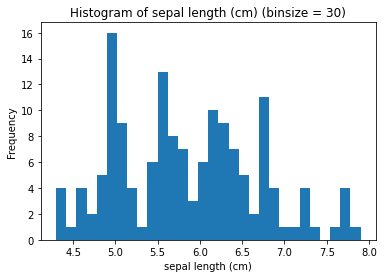

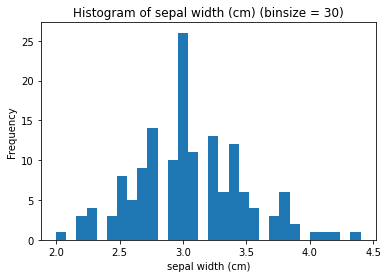

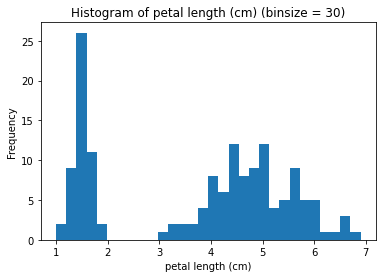

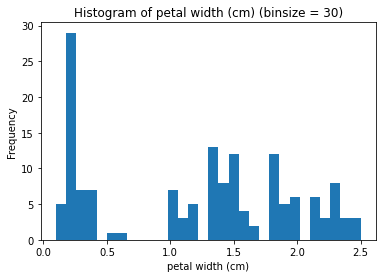

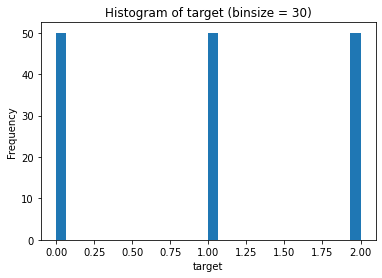

In [6]:
def plot_hist(df, col, bin_size=10):
    """
    function to plot histograms of colummns
    """
    plt.hist(df[col], bins = bin_size)
    plt.title(f'Histogram of {df[col].name} (binsize = {bin_size})')
    plt.xlabel(df[col].name)
    plt.ylabel('Frequency')
    plt.show()

# plot histograms of variables
for col_names in iris_df.columns:
    plot_hist(iris_df, col=col_names, bin_size=30)

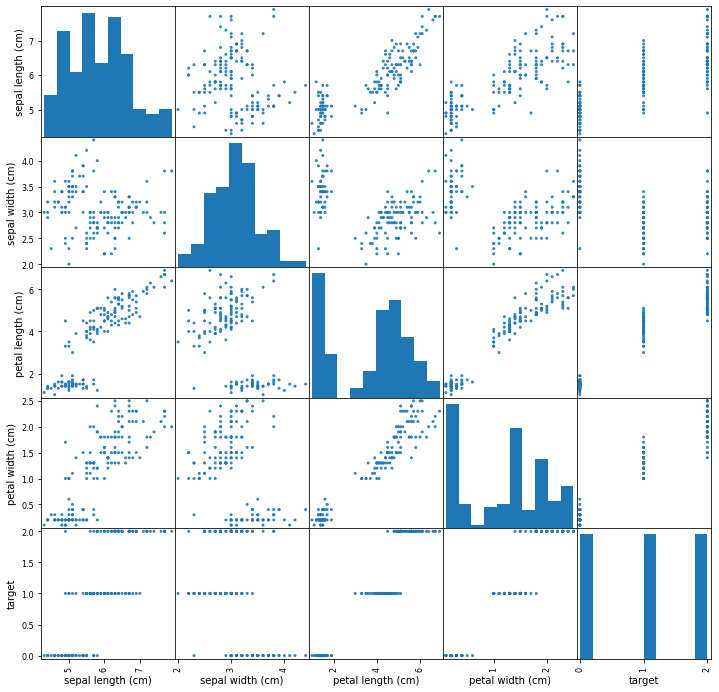

In [80]:
scatter_plot = scatter_matrix(iris_df, figsize=(12, 12), alpha=0.9)

#### model without restrictions 

In [107]:
def run_decision_tree(df, y, df_test, max_depth=30, show_plot=0):
    # initialize and train model
    dtree=DecisionTreeClassifier(max_depth=max_depth)
    dtree.fit(df,y)

    if(show_plot):
        # plot model
        plt.figure(figsize=(20,10))
        tree.plot_tree(dtree, feature_names=list(df.columns), fontsize=10)
        plt.show()

    # evaluate decision tree
    X_test = df_test.drop(labels='target', axis=1)
    y_test = df_test.target

    y_pred = dtree.predict(X_test)

    confusion_matrix(y_true=y_test, y_pred=y_pred)

    accuracy = accuracy_score(y_test, y_pred, normalize=True)
    
    print(f"The accuracy of the given model is {accuracy*100}% (max_depth = {max_depth})")

In [104]:
run_decision_tree(df=df, y=y, df_test=df_test, max_depth=20, show_plot = 0)

The accuracy of the given model is 100.0% (max_depth = 20)


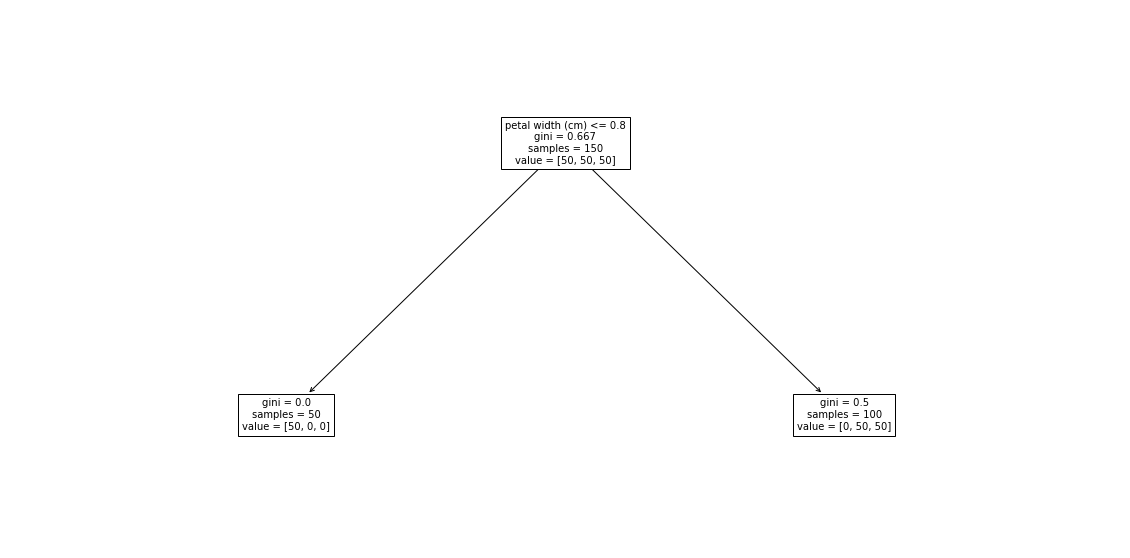

The accuracy of the given model is 66.66666666666666% (max_depth = 1)


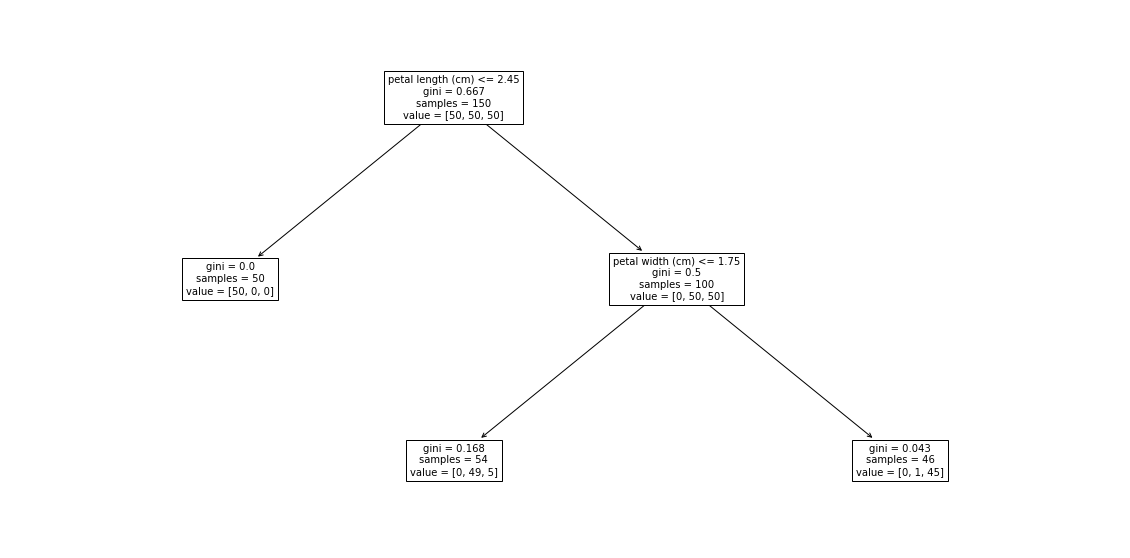

The accuracy of the given model is 93.33333333333333% (max_depth = 2)


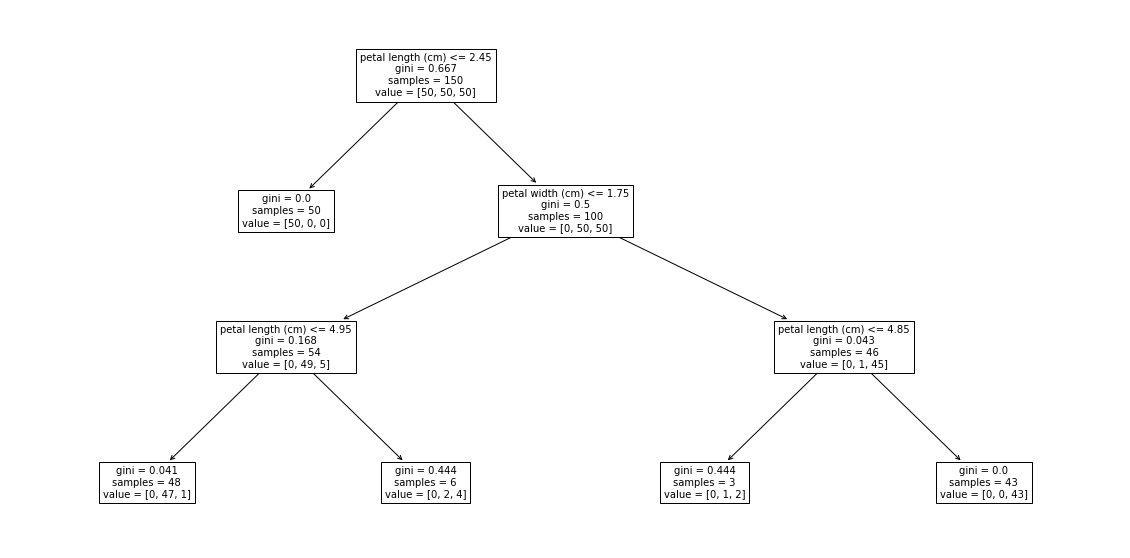

The accuracy of the given model is 100.0% (max_depth = 3)


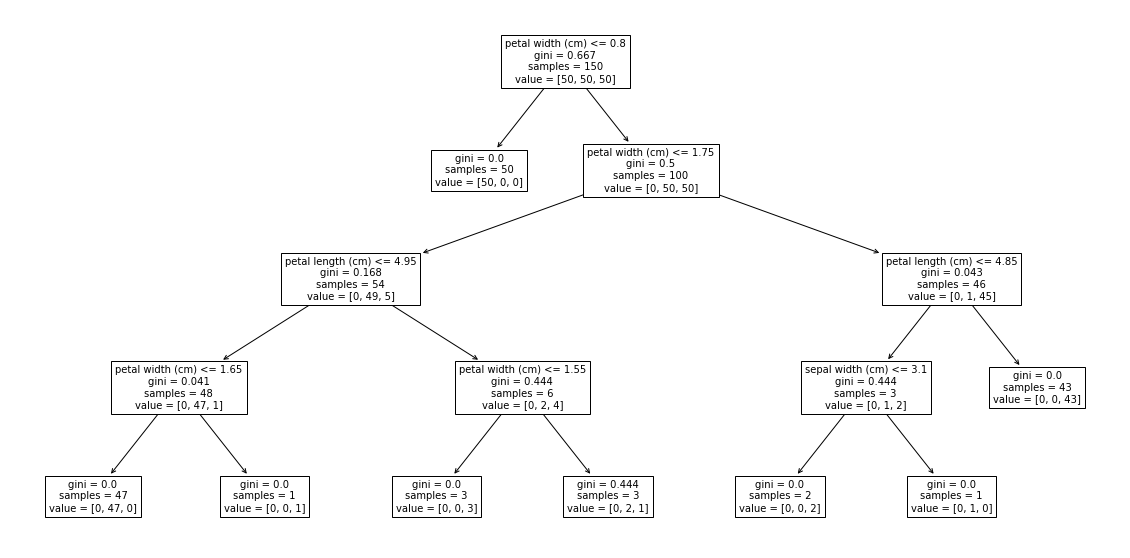

The accuracy of the given model is 97.77777777777777% (max_depth = 4)


In [108]:
for i in range(1, 5):
    run_decision_tree(df=df, y=y, df_test=df_test, max_depth=i, show_plot = 1)